In [14]:
import pandas as pd
import pyodbc

In [15]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")
query = """
SELECT
    f.IPS,
    f."Taux de réussite" AS Taux_Reussite,
    f."Taux de mentions" AS Taux_Mentions,
    f.Nb_eleves,

    -- Geographic info
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,

    -- Etablissement info
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,

    -- Date info
    d.Annee,
    d.Mois,
    d.Jour,

    -- Section info
    s.Code_Section,

    -- Voie info
    v.Code_Voie,

    -- Type Etablissement info
    t.Code_TypeEtab,

    -- Service info
    srv.Code_Service

FROM dbo.factEtablissement2 AS f

-- Join each dimension
LEFT JOIN dbo.dim_geographie AS g
    ON f.Geographie_FK = g.Geographie_PK

LEFT JOIN dbo.dim_etablissment AS e
    ON f.Etablissment_FK = e.Etablissment_PK

LEFT JOIN dbo.dim_Date AS d
    ON f.Date_FK = d.Date_PK

LEFT JOIN dbo.dim_Section AS s
    ON f.Section_FK = s.Section_PK

LEFT JOIN dbo.dim_Voie AS v
    ON f.Voie_FK = v.Voie_PK

LEFT JOIN dbo.dim_TypeEtablissement AS t
    ON f.TypeEtab_FK = t.TypeEtab_PK

LEFT JOIN dbo.dim_Service AS srv
    ON f.Service_FK = srv.Service_PK;

"""

df = pd.read_sql(query, conn)
df.head()
print("Dataframe loaded successfully. Dispalying the first 5 rows:")

Connected successfully


C:\Users\mk\AppData\Local\Temp\ipykernel_21180\123113506.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Dataframe loaded successfully. Dispalying the first 5 rows:


## Initial Data Analysis



In [16]:
# Display basic DataFrame information and statistics
print("First 5 rows of the DataFrame:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the DataFrame:
     IPS Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal     Ville  \
0  121.4            98           55.0      442.0       25000  Besançon   
1  121.4            98           55.0      442.0       25000  Besançon   
2  121.4            98           55.0      442.0       25000  Besançon   
3  121.4            98           55.0      442.0       25000  Besançon   
4  121.4            98           55.0      442.0       25000  Besançon   

                    Region       UAI  \
0  Bourgogne-Franche-Comté  0251021Z   
1  Bourgogne-Franche-Comté  0251021Z   
2  Bourgogne-Franche-Comté  0251021Z   
3  Bourgogne-Franche-Comté  0251021Z   
4  Bourgogne-Franche-Comté  0251021Z   

                                 Nom_Etablissement Statut_Etablissement  \
0  Lycée général et technologique privé Saint-Paul                Privé   
1  Lycée général et technologique privé Saint-Paul                Privé   
2  Lycée général et technologique privé Saint-Paul        

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Taux_Reussite' to numeric, coercing errors
df['Taux_Reussite'] = pd.to_numeric(df['Taux_Reussite'], errors='coerce')

# Display number of missing values after conversion
print("Missing values in 'Taux_Reussite' after conversion:", df['Taux_Reussite'].isnull().sum())

Missing values in 'Taux_Reussite' after conversion: 119690


Number of missing values in 'Taux_Reussite' after filling with median: 0


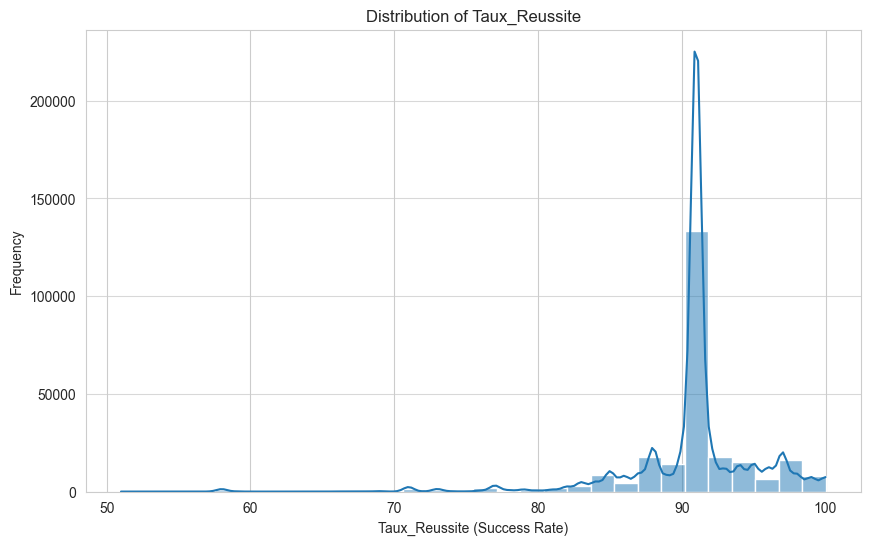

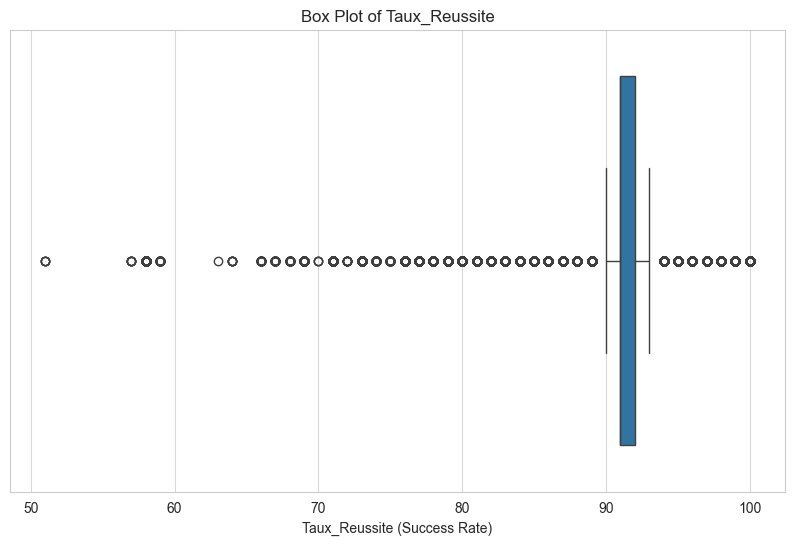

In [18]:
median_taux_reussite = df['Taux_Reussite'].median()
# Impute missing 'Taux_Reussite' values with the median and visualize its distribution
df['Taux_Reussite'] = df['Taux_Reussite'].fillna(median_taux_reussite)
print("Number of missing values in 'Taux_Reussite' after filling with median:", df['Taux_Reussite'].isnull().sum())

# Generate a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Taux_Reussite'], bins=30, kde=True)
plt.title('Distribution of Taux_Reussite')
plt.xlabel('Taux_Reussite (Success Rate)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Taux_Reussite'])
plt.title('Box Plot of Taux_Reussite')
plt.xlabel('Taux_Reussite (Success Rate)')
plt.grid(axis='x', alpha=0.75)
plt.show()

## Handle Missing Values for Features



In [19]:
numerical_cols_with_missing = ['IPS', 'Taux_Mentions', 'Annee', 'Mois', 'Jour']

print("Missing values before numerical imputation:")
print(df[numerical_cols_with_missing].isnull().sum())

# Impute missing numerical values with their median
for col in numerical_cols_with_missing:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

print("\nMissing values after numerical imputation:")
print(df[numerical_cols_with_missing].isnull().sum())

Missing values before numerical imputation:
IPS              19961
Taux_Mentions    48466
Annee             7169
Mois              7169
Jour              7169
dtype: int64

Missing values after numerical imputation:
IPS              0
Taux_Mentions    0
Annee            0
Mois             0
Jour             0
dtype: int64


impute missing values in the specified categorical columns ('Code_Section', 'Code_Voie', 'Code_TypeEtab', 'Code_Service') by replacing them with the string 'Missing'


In [20]:
categorical_cols_with_missing = ['Code_Section', 'Code_Voie', 'Code_TypeEtab', 'Code_Service']

print("\nMissing values before categorical imputation:")
print(df[categorical_cols_with_missing].isnull().sum())

# Impute missing categorical values with 'Missing' category
for col in categorical_cols_with_missing:
    df[col] = df[col].fillna('Missing')

print("\nMissing values after categorical imputation:")
print(df[categorical_cols_with_missing].isnull().sum())

print("\nTotal missing values in DataFrame after all imputations:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values before categorical imputation:
Code_Section     57777
Code_Voie        64404
Code_TypeEtab     2460
Code_Service      1188
dtype: int64

Missing values after categorical imputation:
Code_Section     0
Code_Voie        0
Code_TypeEtab    0
Code_Service     0
dtype: int64

Total missing values in DataFrame after all imputations:
Series([], dtype: int64)


In [21]:
print("Shape before One-Hot Encoding:", df.shape)

# Apply One-Hot Encoding for nominal categorical columns
nominal_categorical_cols = ['Statut_Etablissement', 'Region', 'Code_TypeEtab']
df = pd.get_dummies(df, columns=nominal_categorical_cols, drop_first=False)

print("Shape after One-Hot Encoding:", df.shape)
print("\nFirst 5 rows after One-Hot Encoding:")
print(df.head())

# Identify high-cardinality categorical columns and print unique counts
high_cardinality_cols = ['Ville', 'UAI', 'Nom_Etablissement', 'Code_Section', 'Code_Voie', 'Code_Service']

print("\nUnique values for high-cardinality categorical columns:")
for col in high_cardinality_cols:
    if col in df.columns: # Check if column still exists after one-hot encoding
        print(f"- {col}: {df[col].nunique()} unique values")
    else:
        print(f"- {col}: Column was removed or transformed during previous steps.")

Shape before One-Hot Encoding: (252669, 17)
Shape after One-Hot Encoding: (252669, 39)

First 5 rows after One-Hot Encoding:
     IPS  Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal     Ville  \
0  121.4           98.0           55.0      442.0       25000  Besançon   
1  121.4           98.0           55.0      442.0       25000  Besançon   
2  121.4           98.0           55.0      442.0       25000  Besançon   
3  121.4           98.0           55.0      442.0       25000  Besançon   
4  121.4           98.0           55.0      442.0       25000  Besançon   

        UAI                                Nom_Etablissement   Annee  Mois  \
0  0251021Z  Lycée général et technologique privé Saint-Paul  1967.0   3.0   
1  0251021Z  Lycée général et technologique privé Saint-Paul  1967.0   3.0   
2  0251021Z  Lycée général et technologique privé Saint-Paul  1967.0   3.0   
3  0251021Z  Lycée général et technologique privé Saint-Paul  1967.0   3.0   
4  0251021Z  Lycée général et tech

**Reasoning**:
I will convert the 'Annee', 'Mois', and 'Jour' columns into a single datetime object to facilitate feature engineering, then extract relevant features like 'day_of_week', 'day_of_year', and 'quarter' from this datetime object.



In [22]:
import numpy as np

# Ensure date components are integers
df['Annee'] = df['Annee'].astype(int)
df['Mois'] = df['Mois'].astype(int)
df['Jour'] = df['Jour'].astype(int)

# Create a dictionary for pd.to_datetime with correct key names
date_dict = {
    'year': df['Annee'],
    'month': df['Mois'],
    'day': df['Jour']
}

# Create 'Date' column, coercing invalid dates to NaT
df['Date'] = pd.to_datetime(date_dict, errors='coerce')

# Drop original date columns
df = df.drop(columns=['Annee', 'Mois', 'Jour'])

# Extract temporal features from 'Date' column
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear
df['quarter'] = df['Date'].dt.quarter

# Fill NaN values in extracted features (from NaT dates) with -1
df['day_of_week'] = df['day_of_week'].fillna(-1).astype(int)
df['day_of_year'] = df['day_of_year'].fillna(-1).astype(int)
df['quarter'] = df['quarter'].fillna(-1).astype(int)

# Drop the original 'Date' column
df = df.drop(columns=['Date'])

print("Extracted date features and dropped original date columns. First 5 rows:")
print(df.head())

Extracted date features and dropped original date columns. First 5 rows:
     IPS  Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal     Ville  \
0  121.4           98.0           55.0      442.0       25000  Besançon   
1  121.4           98.0           55.0      442.0       25000  Besançon   
2  121.4           98.0           55.0      442.0       25000  Besançon   
3  121.4           98.0           55.0      442.0       25000  Besançon   
4  121.4           98.0           55.0      442.0       25000  Besançon   

        UAI                                Nom_Etablissement Code_Section  \
0  0251021Z  Lycée général et technologique privé Saint-Paul          ART   
1  0251021Z  Lycée général et technologique privé Saint-Paul          ART   
2  0251021Z  Lycée général et technologique privé Saint-Paul          EUR   
3  0251021Z  Lycée général et technologique privé Saint-Paul          EUR   
4  0251021Z  Lycée général et technologique privé Saint-Paul          THE   

  Code_Voie  

In [23]:
print("Shape before handling remaining categorical columns:", df.shape)

# Apply One-Hot Encoding for lower-cardinality categorical columns
remaining_categorical_cols = ['Code_Section', 'Code_Voie', 'Code_Service']
df = pd.get_dummies(df, columns=remaining_categorical_cols, drop_first=False)

# Drop extremely high-cardinality categorical columns to manage feature space
high_cardinality_to_drop = ['Ville', 'UAI', 'Nom_Etablissement']
df = df.drop(columns=high_cardinality_to_drop, errors='ignore')

print("Shape after handling remaining categorical columns and dropping high cardinality ones:", df.shape)
print("\nFirst 5 rows after all encoding and dropping:")
print(df.head())

Shape before handling remaining categorical columns: (252669, 39)
Shape after handling remaining categorical columns and dropping high cardinality ones: (252669, 52)

First 5 rows after all encoding and dropping:
     IPS  Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal  \
0  121.4           98.0           55.0      442.0       25000   
1  121.4           98.0           55.0      442.0       25000   
2  121.4           98.0           55.0      442.0       25000   
3  121.4           98.0           55.0      442.0       25000   
4  121.4           98.0           55.0      442.0       25000   

   Statut_Etablissement_Privé  Statut_Etablissement_Public  \
0                        True                        False   
1                        True                        False   
2                        True                        False   
3                        True                        False   
4                        True                        False   

   Region_Auvergne-Rhôn

## Exploratory Data Analysis and Visualization for Relationships


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features (X) from target variable (y)
y = df['Taux_Reussite']
X = df.drop('Taux_Reussite', axis=1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Identify numerical columns for scatter plots
numerical_cols = X.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()
numerical_cols_for_scatter = ['IPS', 'Taux_Mentions', 'Nb_eleves', 'Code_Postal', 'day_of_year']

# Identify categorical-like features for box plots (one-hot encoded and engineered date features)
categorical_like_features = [
    col for col in X.columns if X[col].dtype == 'bool'
] + ['day_of_week', 'quarter']

print("\nNumerical Columns for Scatter Plots:")
print(numerical_cols_for_scatter)
print("\nCategorical-like Features for Box Plots:")
print(categorical_like_features)

Shape of X: (252669, 51)
Shape of y: (252669,)

Numerical Columns for Scatter Plots:
['IPS', 'Taux_Mentions', 'Nb_eleves', 'Code_Postal', 'day_of_year']

Categorical-like Features for Box Plots:
['Statut_Etablissement_Privé', 'Statut_Etablissement_Public', 'Region_Auvergne-Rhône-Alpes', 'Region_Bourgogne-Franche-Comté', 'Region_Bretagne', 'Region_Centre-Val de Loire', 'Region_Corse', 'Region_Grand Est', 'Region_Guadeloupe', 'Region_Guyane', 'Region_Hauts-de-France', 'Region_Ile-de-France', 'Region_La Réunion', 'Region_Martinique', 'Region_Mayotte', 'Region_Normandie', 'Region_Nouvelle-Aquitaine', 'Region_Occitanie', 'Region_Pays de la Loire', "Region_Provence-Alpes-Côte d'Azur", 'Region_TOM et Collectivités territoriales', 'Code_TypeEtab_C', 'Code_TypeEtab_E', 'Code_TypeEtab_L', 'Code_TypeEtab_Missing', 'Code_Section_ART', 'Code_Section_CIN', 'Code_Section_EUR', 'Code_Section_INT', 'Code_Section_Missing', 'Code_Section_SPO', 'Code_Section_THE', 'Code_Voie_G', 'Code_Voie_Missing', 'Code

### Interpretation of Actual vs. Predicted Plot


Generating scatter plots for numerical features vs. Taux_Reussite...


DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

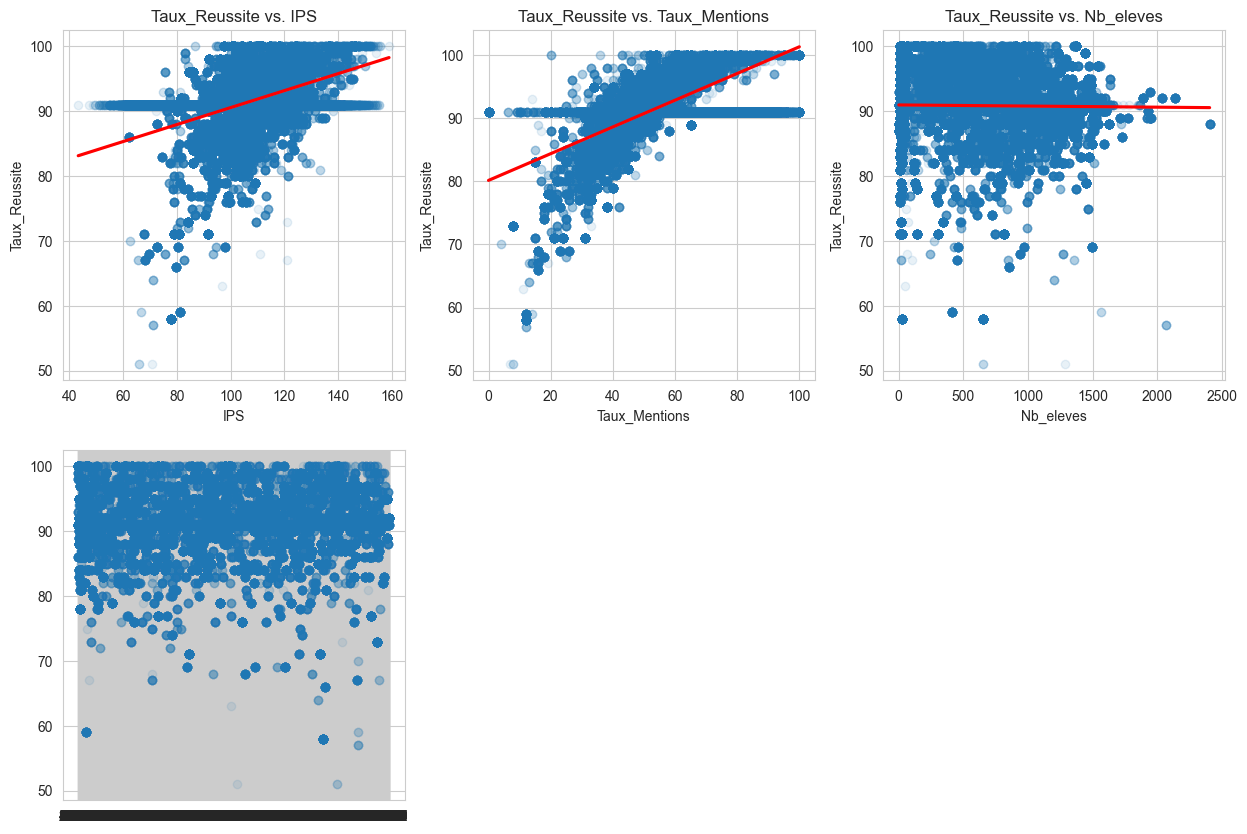

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

print("Generating scatter plots for numerical features vs. Taux_Reussite...")

# Scatter plots for numerical features
num_numerical_cols = len(numerical_cols_for_scatter)
plt.figure(figsize=(15, 5 * ((num_numerical_cols + 2) // 3)))
for i, col in enumerate(numerical_cols_for_scatter):
    plt.subplot((num_numerical_cols + 2) // 3, 3, i + 1)
    sns.regplot(x=X[col], y=y, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
    plt.title(f'Taux_Reussite vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Taux_Reussite')
plt.tight_layout()
plt.show()

print("\nGenerating box plots for selected categorical-like features vs. Taux_Reussite...")

# Box plots for selected categorical-like features
selected_categorical_for_plots = [
    'Statut_Etablissement_Public',
    'Region_Bourgogne-Franche-Comté',
    'Region_Ile-de-France',
    'Code_Section_SPO',
    'Code_Voie_G',
    'day_of_week',
    'quarter'
]

# Prepare data for plotting
plot_data = pd.concat([y, X[selected_categorical_for_plots]], axis=1)

num_selected_categorical = len(selected_categorical_for_plots)
plt.figure(figsize=(15, 5 * ((num_selected_categorical + 2) // 3)))
for i, col in enumerate(selected_categorical_for_plots):
    plt.subplot((num_selected_categorical + 2) // 3, 3, i + 1)
    sns.boxplot(x=plot_data[col], y=plot_data['Taux_Reussite'])
    plt.title(f'Taux_Reussite by {col}')
    plt.xlabel(col)
    plt.ylabel('Taux_Reussite')
plt.tight_layout()
plt.show()

### Analysis of Visualizations for Relationships with 'Taux_Reussite'


## Feature Scaling and Data Splitting



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Numerical features to be scaled
numerical_features_to_scale = ['IPS', 'Taux_Mentions', 'Nb_eleves', 'Code_Postal', 'day_of_year']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Initialize and apply StandardScaler
scaler = StandardScaler()
X_train[numerical_features_to_scale] = scaler.fit_transform(X_train[numerical_features_to_scale])
X_test[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])

print("\nFirst 5 rows of X_train after scaling and splitting:")
print(X_train.head())
print("\nFirst 5 rows of X_test after scaling and splitting:")
print(X_test.head())

Shape of X_train: (202135, 51)
Shape of X_test: (50534, 51)
Shape of y_train: (202135,)
Shape of y_test: (50534,)

First 5 rows of X_train after scaling and splitting:
             IPS  Taux_Mentions  Nb_eleves  Code_Postal  \
78730  -0.435778      -0.054030  -0.144295     0.944285   
88582   0.135046      -0.054030  -0.560254    -1.790185   
203908 -0.597653       0.852564  -0.001612    -1.497691   
80997   0.603633      -0.132601   0.740826    -0.130611   
111263  0.893305       2.145972  -0.308744     1.571169   

        Statut_Etablissement_Privé  Statut_Etablissement_Public  \
78730                        False                         True   
88582                        False                         True   
203908                       False                         True   
80997                         True                        False   
111263                        True                        False   

        Region_Auvergne-Rhône-Alpes  Region_Bourgogne-Franche-Comté  \
787

## Model Selection and Training




In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
gbm_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, n_jobs=-1) # Use all available cores

print("Training RandomForestRegressor...")
rf_model.fit(X_train, y_train)
print("RandomForestRegressor training complete.")

print("\nTraining GradientBoostingRegressor...")
gbm_model.fit(X_train, y_train)
print("GradientBoostingRegressor training complete.")

print("\nTraining XGBRegressor...")
xgb_model.fit(X_train, y_train)
print("XGBRegressor training complete.")

print("Models trained successfully.")

Training RandomForestRegressor...
RandomForestRegressor training complete.

Training GradientBoostingRegressor...
GradientBoostingRegressor training complete.

Training XGBRegressor...
XGBRegressor training complete.
Models trained successfully.


## Model Evaluation and Hyperparameter Tuning




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Evaluate trained models
models = {
    'RandomForestRegressor': rf_model,
    'GradientBoostingRegressor': gbm_model,
    'XGBRegressor': xgb_model
}

print("\n--- Model Evaluation ---")
for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")

# Define parameter distribution for XGBoost hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize and fit RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20, # Reduced for faster execution
    cv=3,       # Reduced for faster execution
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\n--- Starting Hyperparameter Tuning for XGBoost with RandomizedSearchCV ---")
random_search.fit(X_train, y_train)
print("Hyperparameter tuning complete.")

# Print best parameters and RMSE
print("\nBest parameters found:", random_search.best_params_)
best_rmse = np.sqrt(np.abs(random_search.best_score_))
print("Best cross-validation RMSE (from RandomizedSearchCV):", best_rmse)

# Evaluate the best tuned XGBoost model on the test set
best_xgb_model = random_search.best_estimator_
y_pred_tuned_xgb = best_xgb_model.predict(X_test)
mae_tuned_xgb = mean_absolute_error(y_test, y_pred_tuned_xgb)
mse_tuned_xgb = mean_squared_error(y_test, y_pred_tuned_xgb)
rmse_tuned_xgb = np.sqrt(mse_tuned_xgb)
r2_tuned_xgb = r2_score(y_test, y_pred_tuned_xgb)

print("\n--- Evaluation of Tuned XGBoost Model on Test Set ---")
print(f"  Mean Absolute Error (MAE): {mae_tuned_xgb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_tuned_xgb:.4f}")
print(f"  R-squared (R2): {r2_tuned_xgb:.4f}")


--- Model Evaluation ---

RandomForestRegressor:
  Mean Absolute Error (MAE): 0.0065
  Root Mean Squared Error (RMSE): 0.1600
  R-squared (R2): 0.9987

GradientBoostingRegressor:
  Mean Absolute Error (MAE): 1.3611
  Root Mean Squared Error (RMSE): 1.9298
  R-squared (R2): 0.8078

XGBRegressor:
  Mean Absolute Error (MAE): 0.2390
  Root Mean Squared Error (RMSE): 0.5084
  R-squared (R2): 0.9867

--- Starting Hyperparameter Tuning for XGBoost with RandomizedSearchCV ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Hyperparameter tuning complete.

Best parameters found: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best cross-validation RMSE (from RandomizedSearchCV): 0.4472095041170729

--- Evaluation of Tuned XGBoost Model on Test Set ---
  Mean Absolute Error (MAE): 0.2052
  Root Mean Squared Error (RMSE): 0.4318
  R-squared (R2): 0.9904


In [ ]:
# Placeholder for any additional code

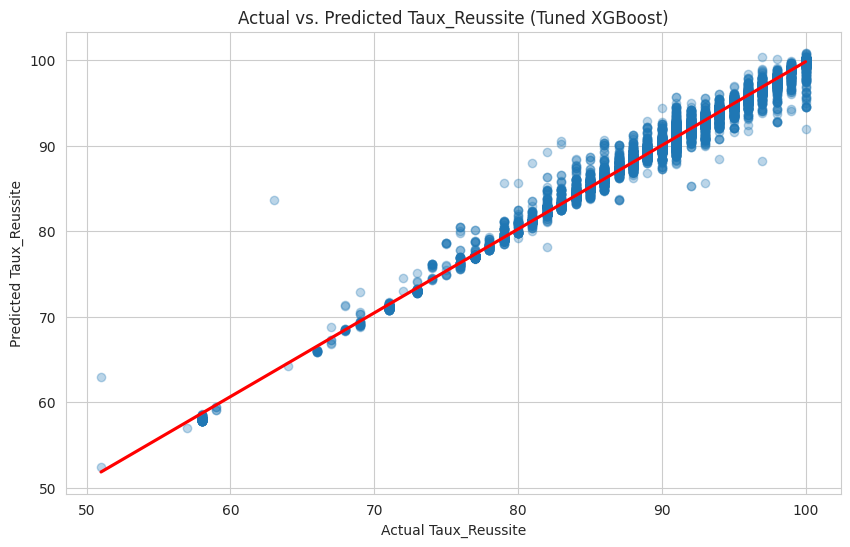

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Actual vs. Predicted values for the Tuned XGBoost Model
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_tuned_xgb, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Actual vs. Predicted Taux_Reussite (Tuned XGBoost)')
plt.xlabel('Actual Taux_Reussite')
plt.ylabel('Predicted Taux_Reussite')
plt.grid(True)
plt.show()

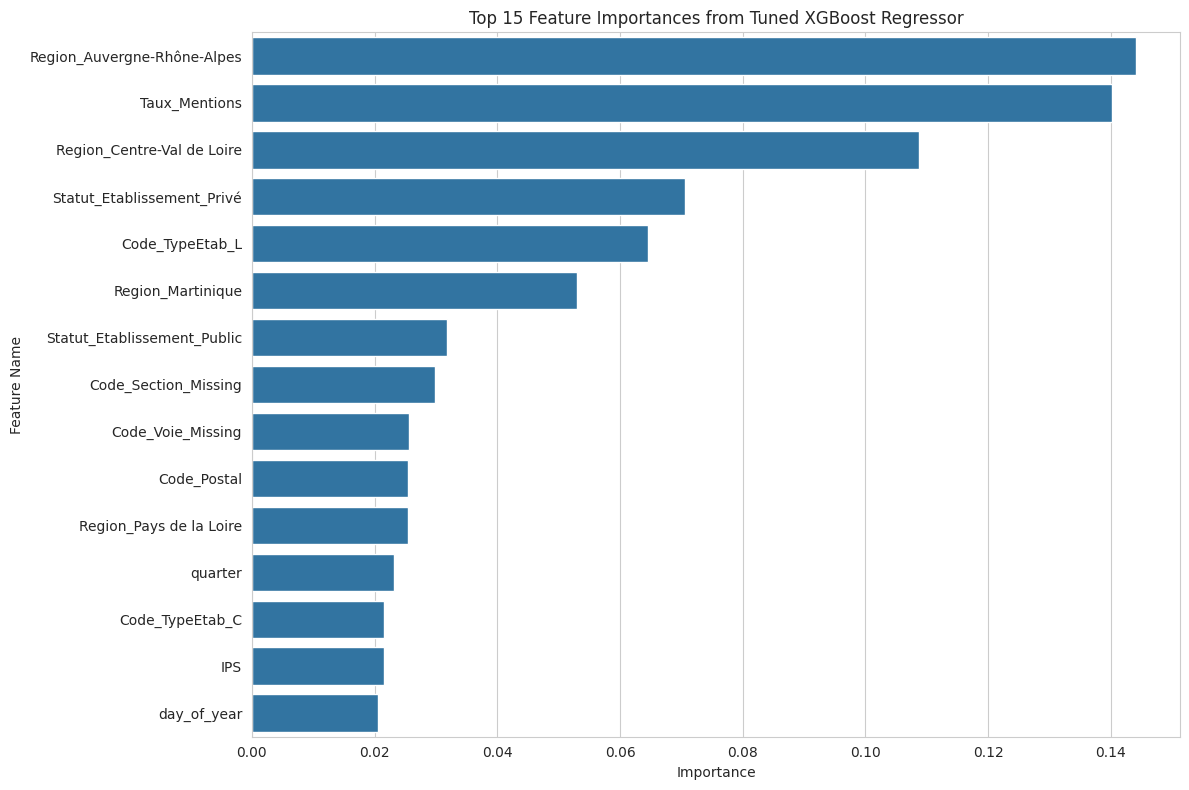

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the tuned XGBoost model
feature_importances_xgb = best_xgb_model.feature_importances_

# Create a pandas DataFrame for feature importances
feature_names_xgb = X_train.columns
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importances_xgb
})

# Sort features by importance in descending order and plot top 15
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb.head(15))
plt.title('Top 15 Feature Importances from Tuned XGBoost Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

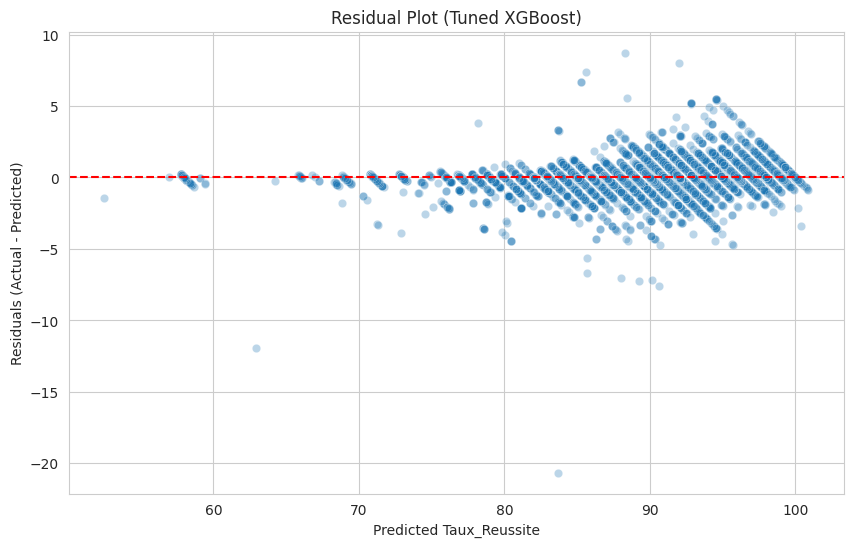

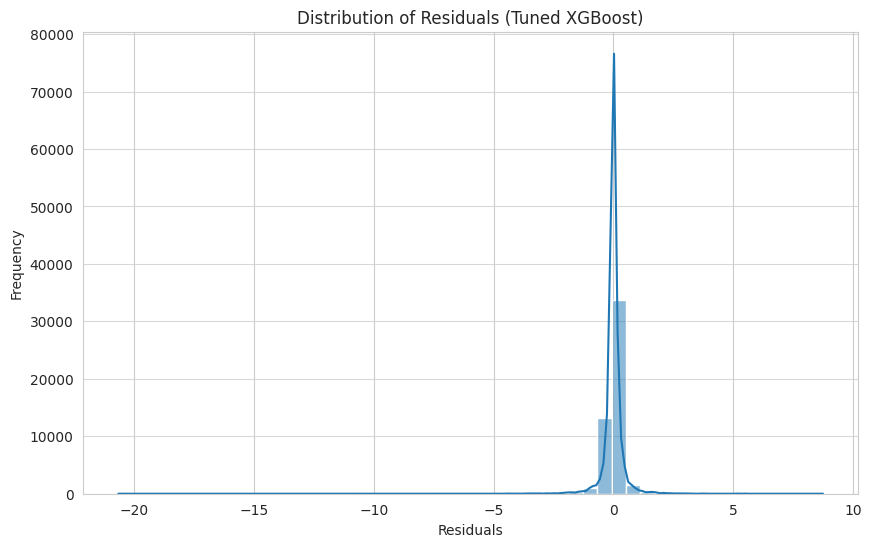

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate residuals for the tuned XGBoost model
residuals = y_test - y_pred_tuned_xgb

# Residual Plot (Predictions vs. Residuals)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_tuned_xgb, y=residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (Tuned XGBoost)')
plt.xlabel('Predicted Taux_Reussite')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals (Tuned XGBoost)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Placeholder for any additional code

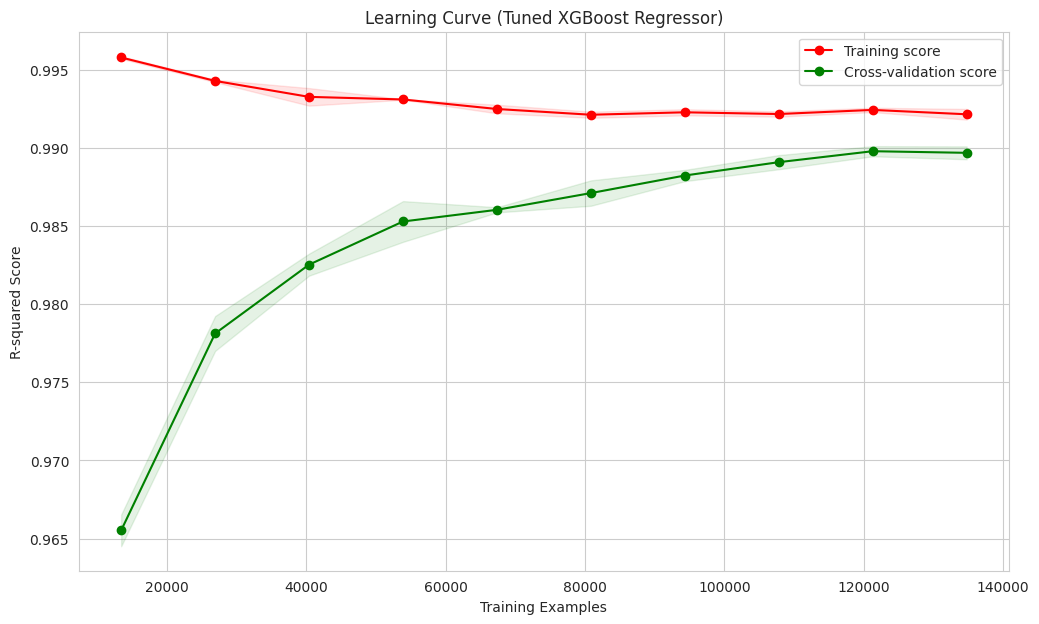

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate learning curve for the tuned XGBoost model
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_xgb_model,
    X=X_train,
    y=y_train,
    cv=3, # Cross-validation folds
    scoring='r2', # Metric for scoring
    n_jobs=-1, # Use all available cores
    train_sizes=np.linspace(0.1, 1.0, 10), # 10 different sizes of the training set
    random_state=42
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(12, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title('Learning Curve (Tuned XGBoost Regressor)')
plt.xlabel('Training Examples')
plt.ylabel('R-squared Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
# Export Actual, Predicted, and Residuals to CSV for Power BI
data_for_powerbi = pd.DataFrame({
    'Actual_Taux_Reussite': y_test.reset_index(drop=True),
    'Predicted_Taux_Reussite': pd.Series(y_pred_tuned_xgb),
    'Residual': y_test.reset_index(drop=True) - pd.Series(y_pred_tuned_xgb)
})

csv_path = 'C:/Users/mk/Downloads/xgb_predictions_residuals_taux_reussite.csv'
data_for_powerbi.to_csv(csv_path, index=False)
print(f"Exported to {csv_path}")
print(data_for_powerbi.head())

NameError: name 'y_test' is not defined